In [1]:
from IPython.display import display
from IPython.display import Image

# gVirtualXRay image vs Plastimatch DRR
**Outline:** the aim of this experiment is to assess the validity of applications that use gVirtualXRay's radiographs. An example being registration between radiographs. We propose that comparing a gVirtualXRay image of a model, generated from a chest phantom CT, to a DRR of the same sample is a good way to test the quality of simulated images because DRR's should be less prone to error than the process used to produce a 3D model of the same sample. It is important that we use a DRR rather than a real radiograph because capturing an image at an exact angle is difficult and using a single reference (The chest CT) between the DRR and the gVirtualXRay model is advantageous to this notebooks integrity.\
**Methods and materials:** A DRR is a radiograph typically reconstructed from CT (hence digitally reconstructed radiograph or DRR). Plastimatch provides a opportunity to generate a close-to true radiograph from CT at a specific orientation. As a coincidence, it is rather easy to produce the same image using gVirtualXRay. This notebook carries a lot of resemblence to notebook 11-gVirtualXRay_vs_lungman.ipynb and we reuse the same lungman model. Many parameters are equal to the previous experiment, with the difference being SAD and SID set effectively to infinity for simple DRR generation (A parallel projection as far as gVirtualXRay is concerned).


We present two orientations in this notebook: a left to right projection; a maximum number of samples approach to test the model and a chest study projection (Anterior to posterior) which demonstrates a realistic use for gVirtualXRay. 

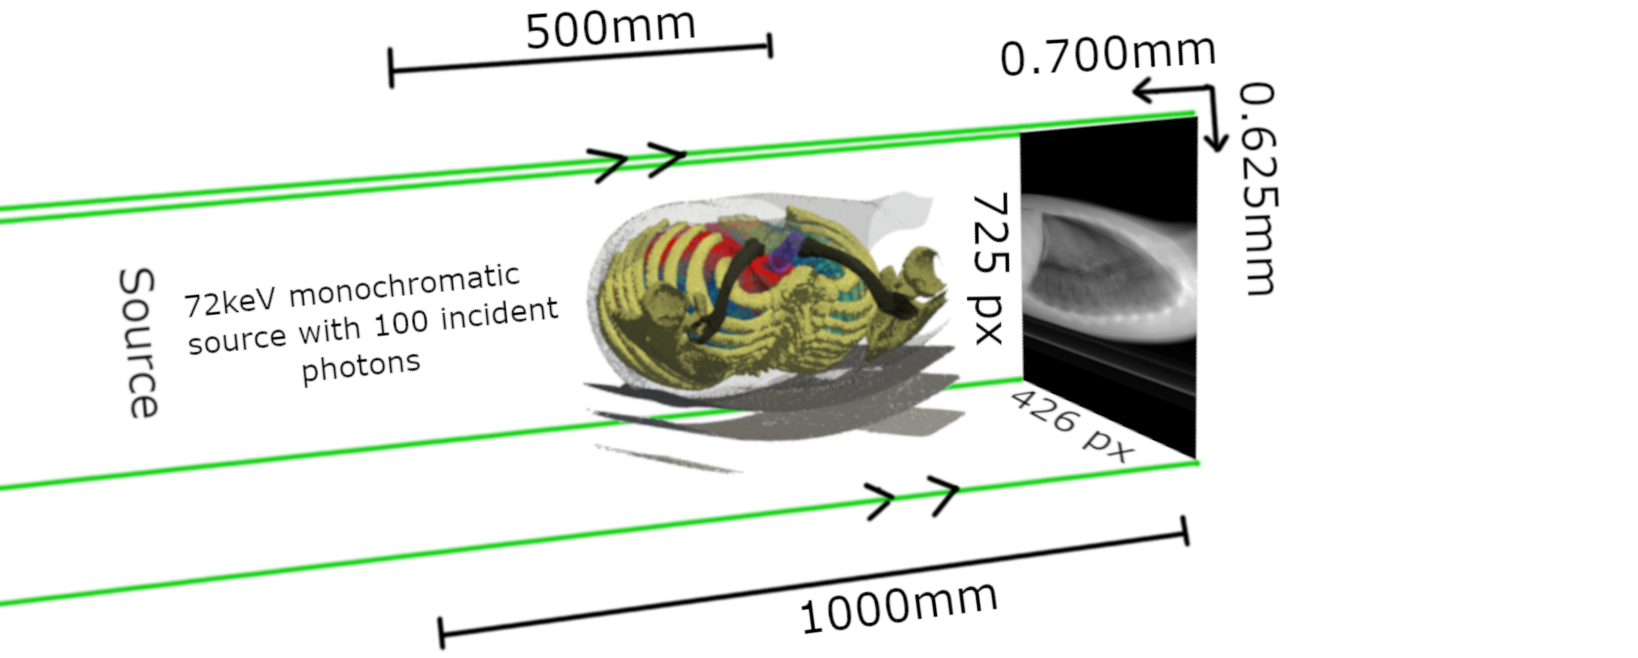

In [2]:
Image("../doc/gvxr-lungman-environment.png", width=800)

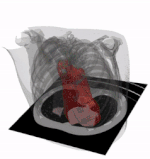

In [3]:
with open('../doc/chest-paraview.gif','rb') as f:
       display(Image(data=f.read(), format='png', width=240))

# Import packages

In [4]:
import os
import SimpleITK as sitk
import numpy as np
from utils import *
from convertRaw import *
import gvxrPython3 as gvxr
import json2gvxr
import matplotlib.pyplot as plt
from tifffile import imread, imsave # Load/Write TIFF files
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error

SimpleGVXR 1.0.1 (2021-12-06T23:05:25) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 1.1.5 (2021-12-06T23:05:24) [Compiler: Microsoft Visual Studio] on Windows


# Configure gVirtualXRay environment

**Create an OpenGL context and window.**

In [5]:
json2gvxr.initGVXR("notebook-11.json", "OPENGL");

Create an OpenGL context: 512x512


**Create a photon beam.**

In [6]:
json2gvxr.initSourceGeometry();

Set up the beam
	Source position: [0, -500, 0, 'mm']
	Source shape: ParallelBeam


**Create a detector array.**

In [7]:
json2gvxr.initDetector("notebook-11.json");

Set up the detector
	Detector position: [0, 500, 0, 'mm']
	Detector up vector: [0, 0, -1]
	Detector number of pixels: [725, 426]
	Pixel spacing: [0.625, 0.7, 'mm']


In [8]:
gvxr.setMonoChromatic(100, "keV", 100);

**Create a phantom model from each mesh and its material.**

In [9]:
json2gvxr.initSamples("notebook-11.json", 1);

Load the 3D data

	Load 100HU_tumours in lungman_data/meshes/tumours_100HU.stl using mm
	Load -630HU_tumours in lungman_data/meshes/tumours_630HU.stl using mm
	Load Clavicle in lungman_data/meshes/clavicle.stl using mm
	Load Heart in lungman_data/meshes/heart.stl using mm
	Load Bronchus in lungman_data/meshes/bronchus.stl using mm
	Load Diaphram in lungman_data/meshes/diaphram.stl using mm
	Load Bronchioles in lungman_data/meshes/bronchioles.stl using mm
	Load Ribs_Spine in lungman_data/meshes/ribs_spine.stl using mm
	Load Scapulas in lungman_data/meshes/scapulas.stl using mm
	Load Sheets_high in lungman_data/meshes/sheets_high.stl using mm
	Load Sheets_low in lungman_data/meshes/sheets_low.stl using mm
	Load Sheets_med in lungman_data/meshes/sheets_med.stl using mm
	Load Skin in lungman_data/meshes/skin.stl using mm
	Load Sternum in lungman_data/meshes/sternum.stl using mm
	Load Trachea in lungman_data/meshes/trachea.stl using mm


**Rotate to achieve the desired orientation and create a gVirtualXRay projection of the scene.**

In [10]:
gvxr.rotateScene(90, 0, 0, 1);
xray_RL = np.array(gvxr.computeXRayImage());

**Rotate again to get a A-P or medical projection.**

In [11]:
gvxr.rotateScene(90, 0, 0, 1);
xray_AP = np.array(gvxr.computeXRayImage());

**Flat field the detector's image.**\
Taking advantage of the detector response when there is no sample can help improve the quality of images when a sample is present. To elaborate, any variance between pixels when the detector is dark (X-Ray beam off) or full (X-Ray beam on) with no density will affect the quality of images with a sample. Factoring for this systematic error is called flat-field correction. \
N: corrected image\
P: projection\
D: dark field\
F: full field\
$N = \frac{P - D}{F - D}$\
In this routine the projection data is flat-fielded.

In [12]:
# Create a mock dark field image
dark_field_image = np.zeros(xray_RL.shape);

# Create a mock flat field image
flat_field_image = np.ones(xray_RL.shape);

# Retrieve the total energy
total_energy = 0.0;
energy_bins = gvxr.getEnergyBins("keV");
photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

for energy, count in zip(energy_bins, photon_count_per_bin):
    total_energy += energy * count;
flat_field_image *= total_energy;
    
# Apply the actual flat-field correction on the raw projections
xray_RL = (xray_RL - dark_field_image) / (flat_field_image - dark_field_image)
xray_AP = (xray_AP - dark_field_image) / (flat_field_image - dark_field_image)
dark_field_image = None
flat_field_image = None

**Normalise the image with a minus log transform.**

Ensure log is greater than or equal t zero.

Perform negative log.

Adjust for pixel spacing.

In [13]:
# Make sure no value is negative or null (because of the log function)
# It should not be the case, however, when the Laplacian is used to simulate
# phase contrast, negative values can be generated.
threshold = 0.000000001
xray_RL[xray_RL < threshold] = threshold;
xray_AP[xray_AP < threshold] = threshold;

# Apply the minus log normalisation
xray_RL = -np.log(xray_RL);
xray_AP = -np.log(xray_AP);

# Rescale the data taking into account the pixel size
pixel_spacing_in_mm = gvxr.getDetectorSize("mm")[0] / gvxr.getDetectorNumberOfPixels()[0]
#xray_RL /= pixel_spacing_in_mm * (gvxr.getUnitOfLength("mm") / gvxr.getUnitOfLength("cm"));
#xray_AP /= pixel_spacing_in_mm * (gvxr.getUnitOfLength("mm") / gvxr.getUnitOfLength("cm"));

# Make sure the data is in single-precision floating-point numbers
xray_RL = np.array(xray_RL).astype(np.float32);
xray_AP = np.array(xray_AP).astype(np.float32);

In [ ]:
def quickCompare(truth, predict, bDoCheckerboard = False):
    nPlots = 2;
    if (bDoCheckerboard): nPlots = 3;
    
    fig, axes = plt.subplots(1, nPlots);
    modeCMap = "gray";
    axes[0].imshow(truth, cmap=modeCMap);
    axes[1].imshow(predict, cmap=modeCMap);
    
    if (bDoCheckerboard):
        imCheck = userCheckerboard(truth, predict, 20);#compare_images(truth, predict, method='checkerboard', n_tiles=(15,15));
        axes[2].imshow(imCheck, cmap=modeCMap);
    
    fig.set_size_inches(20, 20)

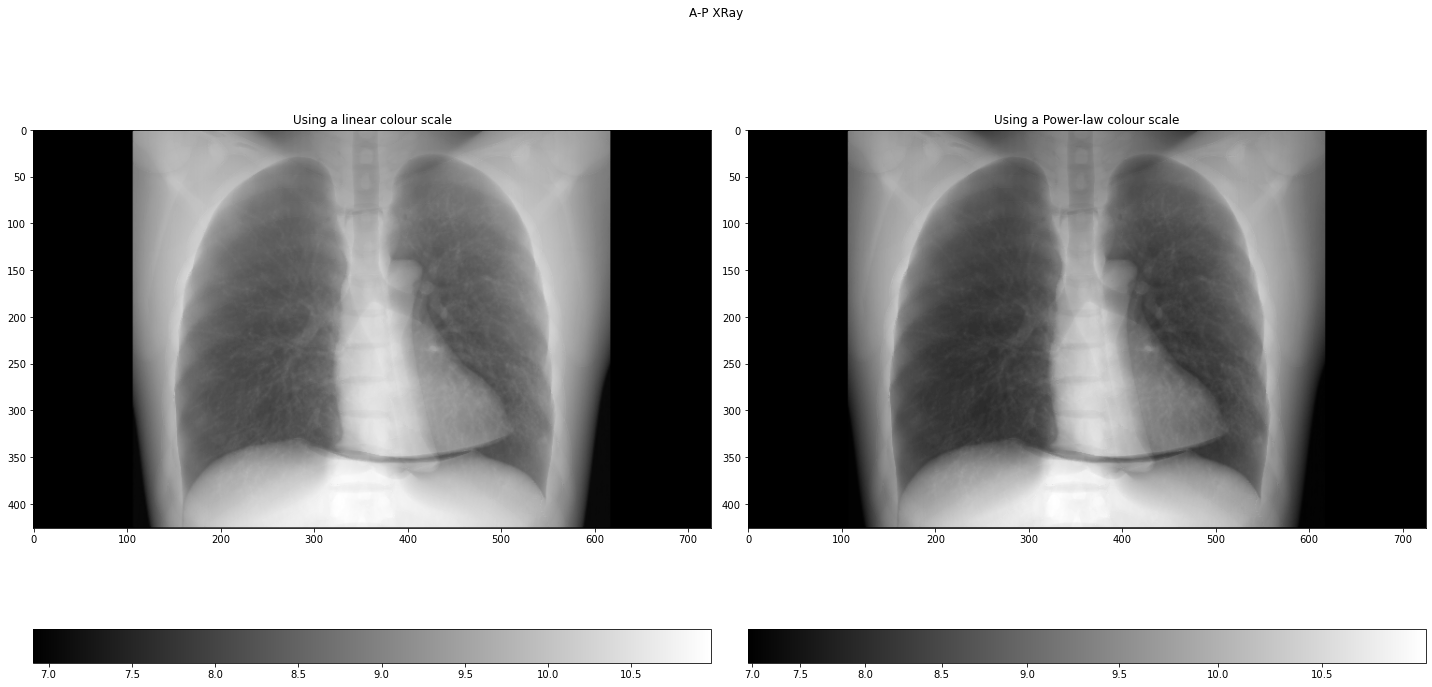

In [15]:
displayLinearPowerScales(xray_AP, "A-P XRay", "plots/xray_AP");

## Plastimatch Parameters
- Normal vector set to 1x,0y,0z or left to right (--nrm)
- Dectector up vector set to 0x,0x,1z (--vup)
- Reconstructed image dimensions 725 by 426 to match gvxr projection (-r)
- Detector size adjusted for spacing $725\times0.625$ by $426\times0.7$ (-z)
- Output type raw (-t)
- Source to detector and source to object set effectively to infinity, mimicking a parellel detector (--sid and --sad)

In [16]:
os.system('plastimatch drr --nrm "1 0 0" --vup "0 0 1" -r "725 426" -c "580 -57" -z "453.125 298.5" -t raw --sid 999999 --sad 999999 --output Plastimatch_data/DRR_RL lungman_data/lungman.mha');

In [17]:
os.system('plastimatch drr --nrm "0 -1 0" --vup "0 0 1" -r "725 426" -c "348 -57" -z "453.125 298.5" -t raw --sid 999999 --sad 999999 --output Plastimatch_data/DRR_AP lungman_data/lungman.mha');

In [18]:
#os.system('python convertRaw.py "Plastimatch_data/lungman_DRR0000.raw" "Plastimatch_data/lungman_DRR.mha" "false" "sitkFloat32" 725 426');

def readPlastimatchImageAsNumpy(path, width, height):
    image_DRR = read_raw(binary_file_name=path,
                 image_size=[width, height],
                 sitk_pixel_type=sitk.sitkFloat32,
                 big_endian="false");
    
    return np.array(sitk.GetArrayFromImage(image_DRR));


In [19]:
DRR_RL = readPlastimatchImageAsNumpy("Plastimatch_data/DRR_RL0000.raw", 725, 426);
DRR_AP = readPlastimatchImageAsNumpy("Plastimatch_data/DRR_AP0000.raw", 725, 426);

[b'ObjectType = Image\n', b'NDims = 2\n', b'DimSize = 725 426\n', b'ElementSpacing = 1 1\n', b'Offset = 0 0\n', b'TransformMatrix = 1 0 0 1\n', b'ElementType = MET_FLOAT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = false\n', b'ElementDataFile = C:\\gvxr-latest\\notebooks\\Plastimatch_data\\DRR_RL0000.raw\n']
[b'ObjectType = Image\n', b'NDims = 2\n', b'DimSize = 725 426\n', b'ElementSpacing = 1 1\n', b'Offset = 0 0\n', b'TransformMatrix = 1 0 0 1\n', b'ElementType = MET_FLOAT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = false\n', b'ElementDataFile = C:\\gvxr-latest\\notebooks\\Plastimatch_data\\DRR_AP0000.raw\n']


In [20]:
def normImage(image_to_normalise):
    #image_to_normalise -= np.mean(image_to_normalise);
    #stddev = np.std(image_to_normalise);
    #image_to_normalise/= float(stddev);
    min = np.min(image_to_normalise);
    max = np.max(image_to_normalise);
    image_to_normalise -= float(min);
    image_to_normalise /= float(max -min);

In [21]:
def mae2D(truth,sim):
    dims = np.shape(truth);
    return np.sum(np.abs(truth - sim)) / float((dims[0] * dims[1]));


In [22]:
xray_AP = xray_AP.astype(np.float64);
DRR_AP = DRR_AP.astype(np.float64);
normImage(xray_AP);
normImage(xray_RL);
normImage(DRR_AP);
normImage(DRR_RL);


true_min = min(np.min(DRR_RL), np.min(xray_RL));
true_max = max(np.max(DRR_RL), np.max(xray_RL));

format = "{head}\nTruth- > {truth:3f} vs {sim:3f} <- Sim\nMAE={mae:3f}\n"
print(format.format(head="A-P \"medical\" DRR vs gvxr comparison",
                    truth=np.mean(DRR_AP), 
                    sim= np.mean(xray_AP),
                    mae=mae2D(DRR_AP, xray_AP)));
print(format.format(head="R-L DRR vs gvxr comparison",
                    truth=np.mean(DRR_RL),
                    sim= np.mean(xray_RL),
                    mae=mae2D(DRR_RL, xray_RL)));

A-P "medical" DRR vs gvxr comparison
Truth- > 0.380852 vs 0.392912 <- Sim
MAE=0.016789

R-L DRR vs gvxr comparison
Truth- > 0.243660 vs 0.238494 <- Sim
MAE=0.015875



## To circumvent issues we encountered with scikit-image's checkerboard comparison we implemented our own... 

In [137]:
def userCheckerboard(truth, predict, nSideLen):
    check = np.copy(truth);
    i =0; j = 0;
    print(truth.shape)
    size = truth.shape[1] * truth.shape[0];
    io = 0;
    yo = 0;
    bOdd  = False;
    while (j < truth.shape[0]):
        for i in range(0, nSideLen):
            if (yo >= truth.shape[1]):
                #bOdd = !bOdd
                if (bOdd == False): bOdd = True;
                else:               bOdd= False;
           
                #if (bOdd)
                if (bOdd == True): yo = 20;
                else:              yo = 0;
                
                j += 1;
                break;
                
            check[j][yo] = predict[j][yo]; #0; #sanity check for odd/even thing
            yo+=1;
          
        yo += 20;
       
            
            
    return check;

In [138]:

thresh = 0.000001;
DRR_AP[DRR_AP < thresh] = thresh;
xray_AP[xray_AP < thresh] = thresh;

#sitk_reader = sitk.ImageFileReader();
#sitk_reader.SetImageIO("MetaImageIO");
#sitk_reader.SetFileName("gVirtualXRay_output_data/gvxr_lungman_1-0-0_radiograph_normalised_402.mha");
#xray_RL = np.array(sitk.GetArrayFromImage(sitk_reader.Execute()));

DRR_RL[DRR_RL < thresh] = thresh;
xray_RL[xray_RL < thresh] = thresh;

(426, 725)


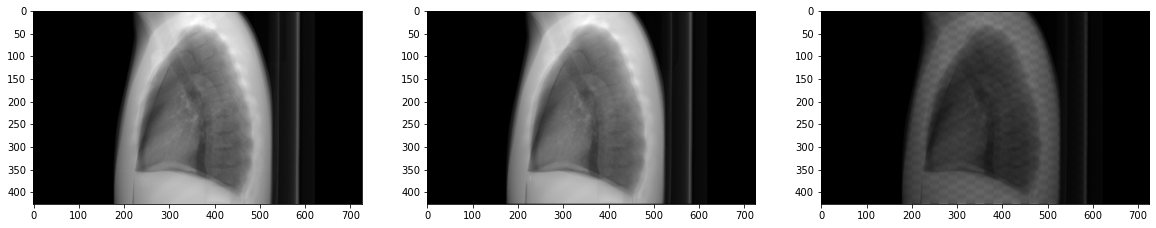

In [139]:
quickCompare(DRR_RL, xray_RL, True);

(426, 725)


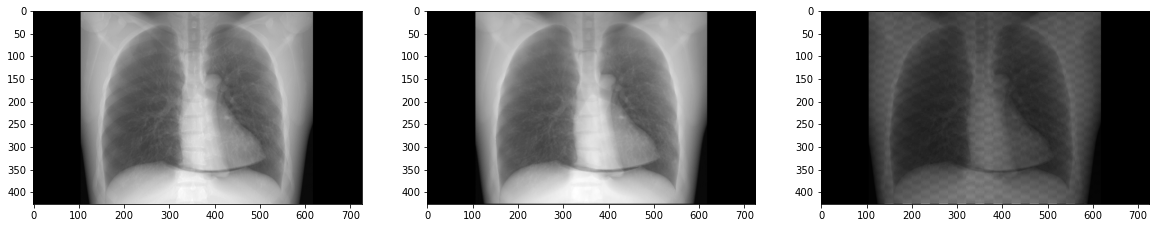

In [140]:
quickCompare(DRR_AP, xray_AP, True);

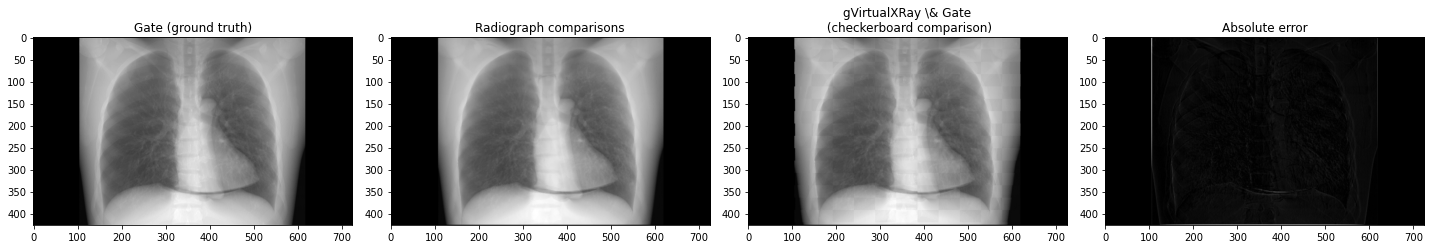

In [124]:
fullCompareImages(DRR_AP, xray_AP, "Radiograph comparisons","plots/lungman_full_comparison_radiographs", vmin = 0,vmax=1);

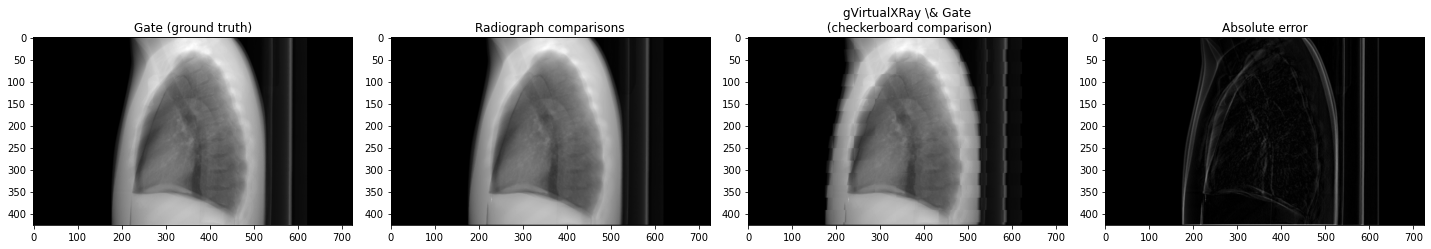

In [28]:
fullCompareImages(DRR_RL, xray_RL, "Radiograph comparisons","plots/lungman_full_comparison_radiographs", vmin = 0,vmax=1);

In [29]:
def calculateZNCC(ground, predict):
    
    dims = np.shape(ground);
    denom = 1.0;
    i = 0;
    while (i < len(dims)):
        denom *= dims[i];
        i+=1;
        
    if (denom == 0): return 0;
    
    ground_std  = np.std(ground);
    predict_std = np.std(predict);
    denom *= (ground_std * predict_std)
    
    ground_mean = np.mean(ground);
    predict_mean = np.mean(predict);
    
    sum = np.sum(
            (ground  - ground_mean)
            *(predict - predict_mean)
            );
        
    zncc_score = sum / denom;
    return zncc_score

In [30]:
zncc_score = calculateZNCC(DRR_AP, xray_AP)
format = "ZNCC score: {score:.3f}%";
print (format.format(score=zncc_score));

ZNCC score: 0.995%


In [31]:
mape_score = mean_absolute_percentage_error(DRR_AP, xray_AP);
format = "MAPE score: {score:.3f}%";
print (format.format(score=mape_score));

MAPE score: 467.791%


In [32]:
ssim_score = ssim(DRR_AP, xray_AP);

format = "SSIM score: {score:.3f}%";
print (format.format(score=ssim_score));

SSIM score: 0.977%
